# Toddler-friendly TripAdvisor Recommendations

This project is inspired by lack of toddler-friendly travel attractions. Most recommendation engines use a broad age range when defining "kid-friendly" although what is appropriate for a 10-year-old may not be suitable or safe for a 3-year-old.

The proposal is to take two-pronged approach:
1. Identify reviewers with toddlers & find "toddler-friendly scores/destinations"
2. Identify "toddler-friendly keywords" from review text

This is the analysis of the data scraped from TripAdvisor website, from my codes in TripAdvisor_get_reviews.ipyn.

Maui TripAdvisor site: https://www.tripadvisor.com/Home-g29220?fid=bf604ef7-d5da-48c9-af9a-288ca0dec18d

# Fun facts

In [1]:
link_file = '/Users/rosaria/Documents/DataScience/DataIncubator/TripAdvisor/attraction_links/maui_hi.txt'
with open(link_file, 'r') as f:
    links = f.read().split('\n')
len(links)

886

- 886 attractions in Maui listed in TripAdvisor
- 2040 reviews scraped for two of the locations (Baby Beach & Haleakala)
    - reviewer id
    - review date
    - rating
    - review text

## Data Wrangling

### 1. Fix problems in data

I had to download data in multiple files for some locations.

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
from IPython.display import display
import ipdb
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# get files from same location together
wd = '/Users/rosaria/Documents/DataScience/DataIncubator/TripAdvisor/reviews/'
files = os.listdir(wd)
attr_to_files = dict()
for file in files:
    attraction = file.split('.txt')[0].split('_page')[0]
    if attraction not in attr_to_files:
        attr_to_files[attraction] = []
    attr_to_files[attraction].append(file)    

In [4]:
files = attr_to_files['Baby_Beach-Lahaina_Maui_Hawaii']
file = files[0]
data = pd.read_csv(wd+file, sep = '\t')
data.head(10)

,reviewer,date,rating,review
0,gaa0805,"November 12, 2018",5.0,"We were in Maui to be married, and we were ori..."
1,Trip54912366173,"October 31, 2018",2.0,Make sure you go to Slaughter House beach as w...
2,leelm321,"October 2, 2018",3.0,"A little rocky, darker coral area, calmer wave..."
3,mbkr312,"September 27, 2018",5.0,"this is a great beach to take young kids, I re..."
4,We were able to find parking on Puunoa Pl.,NaN,NaN,NaN
5,travel_bug0122,"September 18, 2018",5.0,Baby Beach is amazing for young kiddos. We jus...
6,josetK603DP,"September 16, 2018",5.0,We drive around the West Side of Maui looking ...
7,ruthaparness,"September 12, 2018",5.0,Lovely beach with minimal wave action. The wat...
8,amberr475,"September 2, 2018",5.0,This was our favorite beach while on vacation....
9,donaldh175,"August 8, 2018",3.0,Location is OK but dumpy houses on beach. The ...


**Problems in parsing**
What is happening is that there are multiple lines in the review text, and that gets pushed down to reviewer. (I need to come up with a different line separator for writing web scraped data.) Meanwhile, I need to condense the info such that reviewers with date, rating, & review == NaN gets moved to the review in the previous row and delete the row.

1. Identify rows where the date, rating, review == NaN
2. Move misplaced review text to the where it belongs
3. Remove the row where the text was misplaced (rows in step 1)

In [5]:
def fix_review_text(df):
    '''
    For a df, identify rows where review had multiple rows and therefore
    review text got misplaced into the next row's reviewer column
    input: df
    output: cleaned df
    '''
    # get indices with misplaced review text (all other columns are NaN)
    only_review_indices = df.index[df.isnull().any(axis=1)].tolist()

    # find correct index
    index_to_review = dict()
    for index in only_review_indices:
        review = index-1
        while review in index_to_review:
            review -= 1
        index_to_review[index] = review
        
    # put review text in the correct place
    for wrong_index,right_index in index_to_review.items():
        df.loc[right_index, 'review'] += ' '
        df.loc[right_index, 'review'] += df.loc[wrong_index, 'reviewer']
    # drop review text only rows
    return df.dropna()

In [6]:
df = fix_review_text(data)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 166
Data columns (total 4 columns):
reviewer    114 non-null object
date        114 non-null object
rating      114 non-null float64
review      114 non-null object
dtypes: float64(1), object(3)
memory usage: 4.5+ KB


**Change date to datetime object**

In [8]:
def change_to_datetime(df):
    df['date'] = pd.to_datetime(df['date'], format='%B %d, %Y')
    return df

In [9]:
# combined function that I can run for each of the files scraped
def fix_df(raw_data):
    df_fix1 = fix_review_text(raw_data)
    df_fix2 = change_to_datetime(df_fix1)
    return df_fix2

### 2. Merge data for each attraction

In [10]:
pd.options.mode.chained_assignment = None
def merge_data(files):
    '''
    returns merged fixed df
    input: list of files (list of str)
    output: df
    '''
    merged_df = pd.DataFrame()
    for file in files:
        raw_data = pd.read_csv(wd+file, sep='\t')
        fixed_data = fix_df(raw_data)
        merged_df = pd.concat([merged_df, fixed_data], ignore_index=True)
    return merged_df

In [11]:
baby_beach = merge_data(attr_to_files['Baby_Beach-Lahaina_Maui_Hawaii'])
haleakala = merge_data(attr_to_files['Haleakala_National_Park-Kula_Maui_Hawaii'])

In [12]:
baby_beach.shape

(321, 4)

In [13]:
haleakala.shape

(1720, 4)

### 3. Remove duplicate entries

In [14]:
baby_beach_df = baby_beach.drop_duplicates()
haleakala_df = haleakala.drop_duplicates()

In [15]:
baby_beach_df.shape

(290, 4)

In [16]:
haleakala_df.shape

(1720, 4)

### 4. Identify reviews that mention toddlers

In [17]:
age_words = ['toddler', 'little one', 'little kid',
            'young kid', 'young one', 'young child',
            'month old', 'months old', 'month-old', 'months-old',
            '1 year old', '1 year-old', '1-year-old', '1 year',
            '2 year old', '2 year-old', '2-years-old', '2 years old', '2 years-old', '2-years-old', '2 year'
            '3 year old', '3 year-old', '3-years-old', '3 years old', '3 years-old', '3-years-old', '3 year'
            'age 1', 'age 2', 'age 3', 'ages 1', 'ages 2', 'ages 3']

In [18]:
def has_toddler(review):
    ''' 
    returns T/F depending on whether the review contains toddler age words
    input: review_text (str), age_words (list of str)
    '''
    if any(word in review for word in age_words):
        return True
    else:
        return False

In [19]:
def add_has_toddler(df):
    df['has_toddler'] = df['review'].apply(has_toddler)
    return df

In [20]:
baby_beach_df = add_has_toddler(baby_beach_df)
haleakala_df = add_has_toddler(haleakala_df)

## EDA
### 1. How many reviews, reviewers w/ & w/o toddlers?

In [21]:
baby_beach_df.shape

(290, 5)

In [22]:
baby_beach_df.reviewer.nunique()

283

In [23]:
baby_beach_df.groupby('has_toddler').reviewer.count()

has_toddler
False    225
True      65
Name: reviewer, dtype: int64

In [24]:
haleakala_df.shape

(1720, 5)

In [25]:
haleakala_df.reviewer.nunique()

1686

In [26]:
haleakala_df.groupby('has_toddler').reviewer.count()

has_toddler
False    1704
True       16
Name: reviewer, dtype: int64

**make percent stacked bar chart to see proportion of reviews that mention toddlers**

In [27]:
percent_toddler = pd.concat([baby_beach_df.groupby('has_toddler').reviewer.count(),
                                      haleakala_df.groupby('has_toddler').reviewer.count()], axis=1)
percent_toddler.columns = ['baby_beach', 'haleakala']

In [28]:
t = percent_toddler.transpose()
t.columns = ['no_toddler', 'toddler']
t

,no_toddler,toddler
baby_beach,225,65
haleakala,1704,16


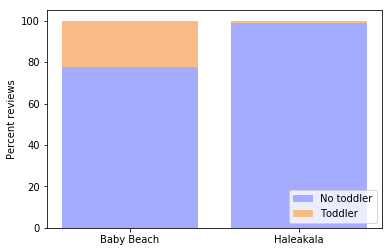

In [29]:
# convert count to percentages
totals = [i+j for i,j in zip(t['no_toddler'], t['toddler'])]
blue_bars = [i/j * 100 for i,j in zip(t['no_toddler'], totals)]
orange_bars = [i/j * 100 for i,j in zip(t['toddler'], totals)]
# plot
tick = ['Baby Beach', 'Haleakala']
plt.bar(tick, blue_bars, color='#a3acff', label='No toddler')
plt.bar(tick, orange_bars, bottom=blue_bars, color='#f9bc86', label='Toddler')
plt.ylabel('Percent reviews')
plt.legend(loc='lower right');

22.4% of the 290 reviews of Baby Beach mentioned toddlers whereas 0.9% of the 1720 review of Haleakala mentioned toddlers. This is already indicative of toddler-friendly attraction. This is probably due to people who research ahead and realize that certain locations are more toddler-friendly.

**should add % reviewers w/ toddlers as a measure of toddler-friendliness** <br>
**should look at reviewers who left multiple reviews for the same location**

### 2. Ratings

In [30]:
baby_beach_df.describe()

,rating
count,290.000000
mean,4.482759
std,0.781299
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [31]:
haleakala_df.describe()

,rating
count,1720.000000
mean,4.798837
std,0.501538
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


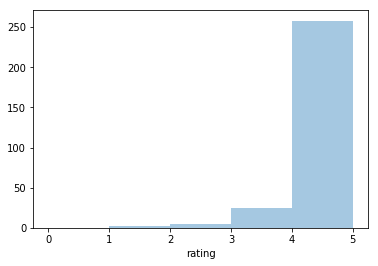

In [32]:
import seaborn as sns
sns.distplot(baby_beach_df.rating, bins=range(6), hist=True, kde=False, rug=False);

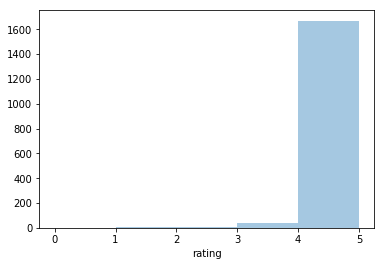

In [33]:
sns.distplot(haleakala_df.rating, bins=range(6), hist=True, kde=False, rug=False);

Both are popular places, so we are getting a lot of good reviews, mostly 5s.

In [34]:
baby_beach_df.groupby('has_toddler')['rating'].mean()

has_toddler
False    4.488889
True     4.461538
Name: rating, dtype: float64

In [35]:
haleakala_df.groupby('has_toddler')['rating'].mean()

has_toddler
False    4.801056
True     4.562500
Name: rating, dtype: float64

**Test if two means are different**

- Null: rating w/ toddler - rating w/o toddler == 0
- Alternative rating w/ toddler - rating w/o toddler != 0

In [36]:
def toddler_mean_different(df):
    n_toddler = (df.has_toddler).sum()
    n_no_toddler = df.shape[0] - n_toddler
    # simulate ratings
    mean_rating_diffs = []
    for _ in range(10000):
        toddler_ratings = np.random.choice(df[df.has_toddler].rating, size=n_toddler)
        no_toddler_ratings = np.random.choice(df[df.has_toddler == False].rating, size=n_no_toddler)
        mean_rating_diffs.append(no_toddler_ratings.mean() - toddler_ratings.mean())
    mean_rating_diffs = np.array(mean_rating_diffs)
    sns.distplot(mean_rating_diffs, hist=True, kde=False, rug=False);
    # compare to actual difference
    actual_ratings = df.groupby('has_toddler')['rating'].mean()
    actual_rating_diff = abs(actual_ratings[False] - actual_ratings[True])
    return ((mean_rating_diffs > actual_rating_diff) | (mean_rating_diffs < - actual_rating_diff)).mean()

0.8199

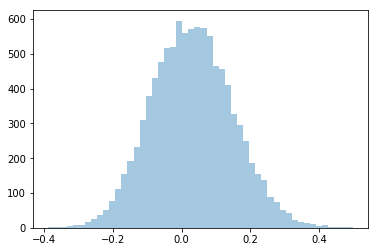

In [37]:
toddler_mean_different(baby_beach_df)

0.4549

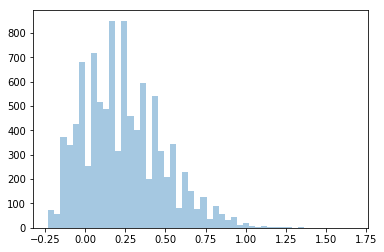

In [38]:
toddler_mean_different(haleakala_df)

The probability that we will observe the difference greater than the actual observed difference by chance is 0.82 for Baby Beach and 0.45 for Haleakala. I cannot reject the null hypothesis for either locations, but the distribution of Haleakala simulation is more skewed right than the Baby Beach simulation, which looks fairly normal. This statistic is probably not very significant due to a low number of reviews that mention toddlers.

### 3. how many of the reviewers went to both locations?

In [39]:
baby_beach_reviewers = set(baby_beach_df['reviewer'])
haleakala_reviewers = set(haleakala_df['reviewer'])

In [40]:
both_reviewers = baby_beach_reviewers & haleakala_reviewers
len(both_reviewers)

13

In [41]:
# get reviews from those reviewers
both_baby_beach = baby_beach_df[baby_beach_df['reviewer'].isin(both_reviewers)]
both_haleakala = haleakala_df[haleakala_df['reviewer'].isin(both_reviewers)]

In [42]:
both_baby_beach

,reviewer,date,rating,review,has_toddler
3,mbkr312,2018-09-27,5.0,"this is a great beach to take young kids, I re...",True
31,blackeldo,2017-10-05,3.0,WHO SAID LAHAINA DIDN’T HAVE A DECENT BEACH? W...,True
53,CCgetoutside,2018-03-27,5.0,We were recommended this beach by a TA expert ...,False
57,merlinsurrietrekker,2018-03-20,4.0,"Within walking distance from downtown Lahaina,...",False
93,tallguyshortgirl,2017-11-18,4.0,20 second walk from our house to sand. Nice qu...,False
94,Glorydays56,2017-11-09,4.0,Checked out many beaches between Lahaina and K...,False
99,blackeldo,2017-10-05,3.0,WHO SAID LAHAINA DIDN’T HAVE A DECENT BEACH? W...,False
132,EmeraldCityGlobeTrtr,2017-05-28,4.0,"Unlike the waves at Ka'anapali, the water here...",False
153,Backpacker83,2017-04-13,4.0,Its a quiet beach that you can find some shade...,False
156,Pisces45,2017-04-10,5.0,"We came here for my wife, a non swimmer, and h...",True


In [43]:
both_haleakala

,reviewer,date,rating,review,has_toddler
824,CCgetoutside,2018-03-27,5.0,"Wow, what a unique experience to see this nati...",False
837,merlinsurrietrekker,2018-03-21,5.0,The views are breathtaking and never disappoin...,False
928,Glorydays56,2017-11-11,5.0,Recently drove up Haleakala to view the sunris...,False
948,blackeldo,2017-10-16,3.0,REAL SIMPLE KEMOSABES: DO THE SUMMIT – GIVE OH...,False
1090,EmeraldCityGlobeTrtr,2017-05-28,5.0,Not sure those words completely do this place ...,False
1108,Backpacker83,2017-05-10,5.0,We sucked it up and woke up early for the sunr...,False
1128,Pisces45,2017-04-18,5.0,This is a must see that is worth the $20 entra...,False
1162,3waytieforlast,2017-03-20,5.0,"if you've got the time and energy, then a thre...",False
1175,A8200SOjacks,2017-03-13,5.0,Haleakala means House of the Sun. It is a very...,False
1304,tallguyshortgirl,2016-11-06,5.0,"Just remember, its nature and won't always coo...",False


- mbkr312 5.0/5.0: has a toddler
- blackeldo 3.0/3.0: no toddler
- CCgetoutside 5.0/5.0: no toddler
- merlinsurrietrekker 4.0/5.0: no toddler
- tallguyshortgirl 4.0/5.0: no toddler
- Glorydays56 4.0/5.0: no toddler
- blackeldo 3.0/3.0: no toddler
- EmeraldCityGlobeTrtr 4.0/5.0: two kids, not sure of age, no mention of them in haleakala
- Backpacker83 4.0/5.0: no toddler 
- Pisces45 5.0/5.0: no toddler
- 3waytieforlast 3.0/5.0: no toddler, two teenagers in haleakala
- DBKuper 4.0/5.0: no toddler
- A8200SOjacks 5.0/5.0: no toddler
- k1w1brad 5.0/5.0: no toddler

There is only one entry where the reviewer has a toddler at both locations. Other has_toddler reviewers mentions seeing toddlers or the Baby Beach being good for toddlers. In general, the rating for Baby Beach is either same or lower than the Haleakala. 

In [44]:
for index,row in both_haleakala.iterrows():
    print(row['reviewer'], row['rating'])
    print(row['review'])
    print('===')

CCgetoutside 5.0
Wow, what a unique experience to see this national park. We drove up in the afternoon, to give us time to explore before the sunset. I would suggest to stop at each opportunity - the views change so much as you climb the volcano. The sunset was by far our favourite moment. Stargazing wasn't as good as it can be since it was a full moon. Worth the admission fee and the trade off is worth the time you could be spending on a beach. *Bring warm clothes and even blankets, toques, mitts etc. very cold as the sun goes down!
===
merlinsurrietrekker 5.0
The views are breathtaking and never disappoint, no matter the season or time of day. We had the great experience of seeing the sunrise and the sunset in just a few days. Both provided a magical time, the sunrise with a beautiful native chant. The sunset provided an opportunity for folks old & young to share an incredible view. Don’t hesitate to make time to experience this yourself.
===
Glorydays56 5.0
Recently drove up Haleaka

## To do:
- how to deal with nonunique reviewers (reviewers who give multiple reviews for the same location)
- extract other reviews of the reviewers who mention toddlers
    - make sure that they indeed have toddlers
    - get reviews for other locations (make sure that the date range falls within when the person would still have toddlers)
- refine how to look for reviews that mention toddlers (NLP?)
- have % reviews that mention toddler as a measure of friendliness
- scrape more data